In [1]:
import sys; sys.path.insert(0, "..")
from src.models import NLM
from src.utils import generate_data, neg_log_likelihood, epistemic_uncertainty

In [2]:
from autograd import numpy as np
import matplotlib.pyplot as plt

### The Problem: Pedagogical Example

The paper argues that the main problem with NLMs is that they are unable to express the desired uncertainty behavior in data-scare regions when using regularization. Below, we walk through generating two NLMs, one with no regularization and the other with regularization, on the same cubic gap toy dataset.

First, we generate the toy data and setup the NLM architecture. We will import our NLM class. To see the NLM class implementation, please see [LINK]. Both NLM models will be using the same architecture: the only difference will be the regularization parameter. 

In [3]:
x, y, x_test, y_test = generate_data(number_of_points=50, noise_variance=9)

gap_idx = np.logical_and(x_test > -2, x_test < 2)
x_test_gap = x_test[gap_idx].reshape(1,-1)
y_test_gap = y_test[gap_idx].reshape(1,-1)

non_gap_idx = np.logical_or(np.logical_and(x_test > -4, x_test < -2),np.logical_and(x_test > 2, x_test < 4))
x_test_non_gap = x_test[non_gap_idx].reshape(1,-1)
y_test_non_gap = y_test[non_gap_idx].reshape(1,-1)

###relu activation
activation_fn_type = 'relu'
activation_fn = lambda x: np.maximum(np.zeros(x.shape), x)

width = [50,50] # using the architecture used in the paper
hidden_layers = len(width)
input_dim = 1
output_dim = 1

architecture = {'width': width,
               'hidden_layers': hidden_layers,
               'input_dim': input_dim,
               'output_dim': output_dim,
               'activation_fn_type': 'relu',
               'activation_fn_params': 'rate=1',
               'activation_fn': activation_fn}

#set random state to make the experiments replicable
rand_state = 207
random = np.random.RandomState(rand_state)

#instantiate a Feedforward neural network object
nn = NLM(architecture, random=random)
print('Number of parameters =', nn.D)

###define design choices in gradient descent
params = {'step_size':1e-2, 
          'max_iteration':10000, 
          'random_restarts':1}

prior_var = 9
noise_var = 9

Number of parameters = 2701


We train two different NLMs, one with regularization = 0 and regularization = 100. 

In [4]:
nlms = []
reg_params = [0, 100]

for reg_param in reg_params:
    print("Regulariation parameter: {}".format(reg_param))
    params['reg_param'] = reg_param
    nn_i = NLM(architecture, random=random)
    nlms.append(nn_i)
    nn_i.fit(x.reshape((1, -1)), y.reshape((1, -1)), params)
    print("")

Regulariation parameter: 0
Iteration 0 loss 6218.1870889506135; gradient mag: 15491.49486416224
Iteration 100 loss 16.764082116721276; gradient mag: 29.72222417444371
Iteration 200 loss 14.601057938625939; gradient mag: 4.130250691372287
Iteration 300 loss 14.09731112365986; gradient mag: 2.1427723852693674
Iteration 400 loss 13.879221442780661; gradient mag: 3.9949591693454036
Iteration 500 loss 13.508977973921903; gradient mag: 15.760158836748737
Iteration 600 loss 11.31081882259754; gradient mag: 16.000770703587012
Iteration 700 loss 8.799642839875006; gradient mag: 6.600990709984
Iteration 800 loss 7.891696983530599; gradient mag: 20.605311944353723
Iteration 900 loss 7.6281833139492266; gradient mag: 18.865993590439835
Iteration 1000 loss 7.754504016929015; gradient mag: 147.1616345498821
Iteration 1100 loss 7.549213168978792; gradient mag: 57.10387428413349
Iteration 1200 loss 7.515534375536519; gradient mag: 46.37855344339818
Iteration 1300 loss 7.504805906938605; gradient mag: 

Iteration 1500 loss 47.010751734023664; gradient mag: 9.859202179424386
Iteration 1600 loss 45.407181032541864; gradient mag: 12.12440122213784
Iteration 1700 loss 43.96111356068339; gradient mag: 24.5297807127538
Iteration 1800 loss 42.472572507038876; gradient mag: 21.146795300300962
Iteration 1900 loss 41.08877889068445; gradient mag: 18.42711331117524
Iteration 2000 loss 39.74511739027111; gradient mag: 23.210072251863593
Iteration 2100 loss 38.44093512664507; gradient mag: 13.23696481066997
Iteration 2200 loss 37.179040804178065; gradient mag: 21.77098706154631
Iteration 2300 loss 35.95764590190177; gradient mag: 4.905767907283731
Iteration 2400 loss 34.78147945651834; gradient mag: 20.96827258672082
Iteration 2500 loss 33.63239323341839; gradient mag: 6.475909444246122
Iteration 2600 loss 32.521310195978295; gradient mag: 6.320583325748679
Iteration 2700 loss 31.46050603504682; gradient mag: 21.871757678457385
Iteration 2800 loss 30.42149500381816; gradient mag: 5.231968018836611

Now we can calculate and visualize the prior samples and posterior predictive samples, once again using the imported NLM class. 

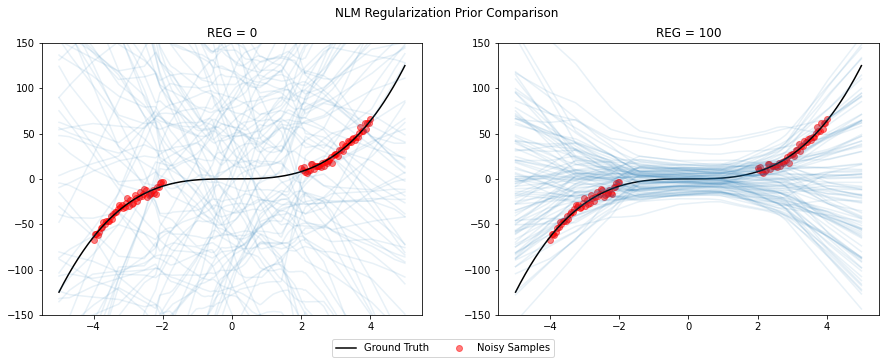

In [5]:
fig, axs = plt.subplots(1, 2, figsize = (15, 5))

for i, ax in enumerate(axs.ravel()):
    nlm = nlms[i]
    y_prior = nlm.get_prior_preds(x_test, w_prior_mean = 0, w_prior_cov = prior_var, noise_var = noise_var)
        
    ax.scatter(x,y, color='red', alpha = 0.5, label='Noisy Samples')
    ax.plot(x_test[0,:], y_test[0, :], color='black', label="Ground Truth")
    ax.plot(x_test[0,:], y_prior.T, color='tab:blue', alpha=0.1)
    
    ax.set_ylim([-150, 150])
    
    ax.set_title("REG = {}".format(reg_params[i]))
    
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=2)

plt.suptitle("NLM Regularization Prior Comparison")

plt.show()

In the plots above, we recreated the example given in the paper showing that NLMs with no regularization can produce expressive prior samples. Meanwhile, a regularization parameter of 100 produces far less expressive prior samples, particularly in the data-scare region of the gap. 

Note: Our regularization is normalized by the number of samples. For this reason, our regularization parameters are of a higher order magnitude than those in the paper. 

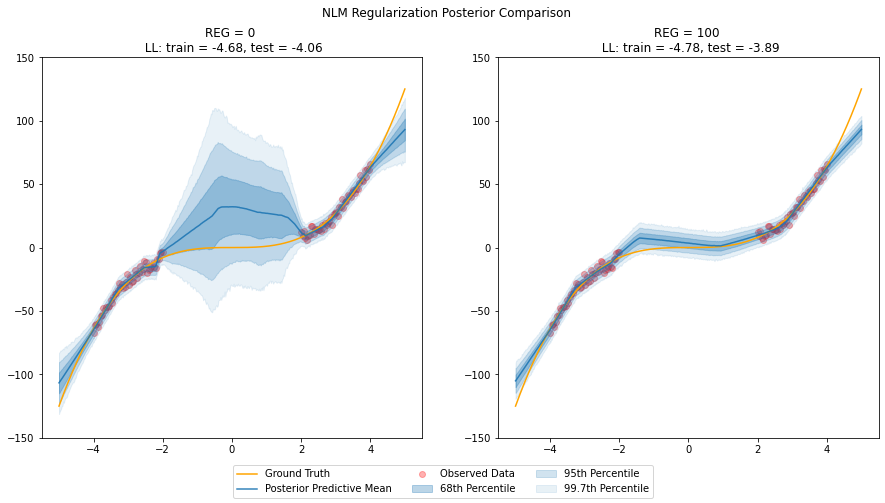

In [6]:
fig, axs = plt.subplots(1, 2, figsize = (15, 7))

lls_train = []
lls_test = []

for i, ax in enumerate(axs.ravel()):
    nlm = nlms[i]
    
    # Calculate Posteriors
    y_posterior = nlm.get_posterior_preds(x_test, x_obs=x, y_obs=y, w_prior_cov=prior_var, noise_var=noise_var, n_models = 5000)
    y_posterior = y_posterior + np.random.normal(0, noise_var**0.5, size=y_posterior.shape)
    
    posterior_predictive_train = nlm.get_posterior_preds(x, x_obs=x, y_obs=y, w_prior_cov=prior_var, noise_var=noise_var)
    posterior_predictive_train = posterior_predictive_train + np.random.normal(0, noise_var**0.5, size=posterior_predictive_train.shape)

    posterior_predictive_non_gap = nlm.get_posterior_preds(x_test_non_gap, x_obs=x, y_obs=y, w_prior_cov=prior_var, noise_var=noise_var)
    posterior_predictive_non_gap = posterior_predictive_non_gap + np.random.normal(0, noise_var**0.5, size=posterior_predictive_non_gap.shape)

    # Calculate Log-Likelihoods
    lls_train.append(neg_log_likelihood(posterior_predictive_train, y, noise_var) * -1)
    lls_test.append(neg_log_likelihood(posterior_predictive_non_gap, y_test_non_gap, noise_var) * -1)

    # Calculating Percentiles
    pp_upper = np.percentile(y_posterior, 97.5, axis=0)
    pp_lower = np.percentile(y_posterior, 2.5, axis=0)
    pp_upper2 = np.percentile(y_posterior, 84, axis=0)
    pp_lower2 = np.percentile(y_posterior, 16, axis=0)
    pp_upper3 = np.percentile(y_posterior, 99.85, axis=0)
    pp_lower3 = np.percentile(y_posterior, 0.15, axis=0)
    pp_mean = np.mean(y_posterior, axis=0)

    # Visualizing 68%/95%/99.7% posterior predictive interval of Bayesian polynomial regression
    ax.scatter(x[0,:], y[0,:], color='red', alpha=0.3, label='Observed Data')
    ax.plot(x_test[0,:], y_test[0,:], color='orange', label="Ground Truth")
    ax.plot(x_test[0,:], pp_mean, color='tab:blue', alpha=0.9, label='Posterior Predictive Mean')
    ax.fill_between(x_test[0,:], pp_upper2, pp_lower2, color = 'tab:blue', alpha = 0.3, label="68th Percentile")
    ax.fill_between(x_test[0,:], pp_upper, pp_lower, color='tab:blue', alpha=0.2, label="95th Percentile")
    ax.fill_between(x_test[0,:], pp_upper3, pp_lower3, color = 'tab:blue', alpha = 0.1, label="99.7th Percentile")
        
    ax.set_ylim([-150, 150])
    
    ax.set_title("REG = {:.0f} \n LL: train = {:.2f}, test = {:.2f}".format(reg_params[i], lls_train[i], lls_test[i]))

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=3)

plt.suptitle("NLM Regularization Posterior Comparison")

plt.show()

Likewise, NLMs with no regularization are able to express the desired uncertainty in the data-scare region. Meanwhile, the NLM with a regularization parameter of 100 expresses no uncertainty in the data-scare region. The log-likelihoods of the two models demonstrate that log-likehiood cannot be used a measure of the quality of the uncertainty in this gap region. The model with no regularization shows a higher train LL but a lower test LL than the model with regularization = 100. Thus, a lower (or higher) LL does not automatically indicate better uncertainty quality.